##### Copyright 2024 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using LIT to Analyze Gemma Models in Keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/gemma/docs/lit_gemma"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on Generative AI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/lit_gemma.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemma/docs/lit_gemma.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://codelabs.developers.google.com/codelabs/responsible-ai/lit-gemma"><img src="https://www.tensorflow.org/images/codelabs_logo.png" height="24" width="48" />Learn in Codelabs</a>
  </td>
</table>

## Introduction

Generative AI products are relatively new and the behaviors of an application
can vary more than earlier forms of software. This makes it important to probe
the machine learning models being used, examine examples of the model's
behavior and investigate surprises.

The Learning Interpretability Tool (LIT; [website][lit-web], [GitHub][lit-gh])
is a platform for debugging and analyzing ML models to understand why and how
they behave the way they do.

In this codelab, you'll learn how to use LIT to get more out of Google's
[Gemma model][gemma]. This codelab demonstrates how to use sequence salience, an
interpretability technique, to analyze different prompt engineering approaches.

Learning objectives:

1. Understanding sequence salience and its uses in model analysis.
1. Setting up LIT for Gemma to compute prompt outputs and sequence salience.
1. Using sequence salience through the _LM Salience_ module to understand the
   impact of prompt designs on model outputs.
1. Testing hypothesized prompt improvements in LIT and see their impact.

_Note: that this codelab uses the [KerasNLP implementation][keras-nlp] of Gemma,
and TensorFlow v2 for the backend. It's highly recommended using a GPU kernel to
follow along._

[lit-web]: https://pair-code.github.io/lit
[lit-gh]: https://github.com/PAIR-code/lit
[gemma]: https://ai.google.dev/gemma
[keras-nlp]: https://keras.io/keras_nlp/

## Sequence Salience and its Uses in Model Analysis

Text-to-text generative models, such as Gemma, take an input sequence in the
form of [tokenized](https://arxiv.org/pdf/1808.06226.pdf) text and generate new
tokens that are typical follow-ons or completions to that input. This
generation happens one token at a time, appending (in a loop) each newly
generated token to the input plus any previous generations until the model
reaches a stopping condition. Examples include when the model generates an
[end-of-sequence (EOS) token][eos-token] or reaches the predefined maximum
length.

Salience methods are a class of explainable AI (XAI) techniques that can tell
you which parts of an input are important to the model for different parts of
its output. LIT supports [salience methods for a variety of
classification tasks][text-salience], which explain the impact of a sequence of
input tokens on the predicted label. Sequence salience generalizes these
methods to text-to-text generative models and explains the impact of the
preceding tokens on the generated tokens.

You'll use the [Grad L2 Norm](https://aclanthology.org/P18-1032/) method here
for sequence salience, which analyzes the gradients of the model and provides a
magnitude of the influence that each preceding token has on the output. This
method is simple and efficient, and has been [shown][shortcuts-paper] to
perform well in classification and other settings. The larger the salience
score, the higher the influence. This method is used within LIT because it's
well-understood and utilized widely across the interpretability research
community.

More advanced gradient-based salience methods include
[Grad &sdot; Input][grad-x-input] and [integrated gradients][inter-grad]. There
are also ablation-based methods available, such as [LIME][lime] and
[SHAP][shap], which can be more robust but significantly more expensive to
compute. Refer to [this article](https://arxiv.org/abs/2111.07367) for a
detailed comparison of different salience methods.

You can learn more about the science of salience methods in [this introductory
interactive explorable to salience][salience-explorable].

[eos-token]: https://huggingface.co/docs/transformers/en/llm_tutorial#generate-text
[shortcuts-paper]: http://arxiv.org/abs/2111.07367
[text-salience]: https://pair-code.github.io/lit/tutorials/text-salience/
[grad-x-input]: https://arxiv.org/abs/1412.6815
[inter-grad]: https://arxiv.org/abs/1703.01365
[lime]: https://arxiv.org/abs/1602.04938
[shap]: https://papers.nips.cc/paper_files/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html
[salience-explorable]: https://pair.withgoogle.com/explorables/saliency/

# Imports, Environment, and Other Setup Code

*Note: you may see some warnings of the form*
```
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.21.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 8.14.0 which is incompatible.
```

*These are safe to ignore.*

### Install LIT and Keras NLP

For this codelab, you will need a recent version of `keras` (3) `keras-nlp`
(0.8.0) and `lit-nlp` (1.1), and a Kaggle account to download the base model.

In [ ]:
!pip install -q -U lit-nlp
!pip uninstall -y umap-learn
!pip install -q -U keras-nlp
!pip install -q -U keras

### Kaggle Access

To login to Kaggle, you can either store your `kaggle.json` credentials file at
`~/.kaggle/kaggle.json` or run the following in a Colab environment. See the
[`kagglehub` package documentation](https://github.com/Kaggle/kagglehub#authenticate)
for more details.

In [ ]:
import kagglehub

kagglehub.login()

Be sure to also accept the license agreement for [Gemma](https://www.kaggle.com/models/keras/gemma).

# Setting up LIT for Gemma

## Setting up LIT Models

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

In [ ]:
import keras
import keras_nlp

# Run at half precision.
keras.config.set_floatx("bfloat16")

In [ ]:
model_name = 'gemma_instruct_2b_en'
gemma_model = keras_nlp.models.GemmaCausalLM.from_preset(model_name)

The following code initializes the LIT wrappers to support salience on the Gemma
model. The LIT framework refers to these as models, but in this case they are
just different endpoints for the same underlying `gemma_model` you loaded above.
This enables LIT to compute generations, tokenization, and salience on-demand.

In [ ]:
from lit_nlp.examples.models import instrumented_keras_lms

batch_size = 1 #@param {type: "integer"}
max_sequence_length = 512 #@param {type: "integer"}
init_models = instrumented_keras_lms.initialize_model_group_for_salience
models = init_models(model_name, gemma_model,
                     batch_size=batch_size,
                     max_length=max_sequence_length)

## Setting up LIT datasets

Gemma is a text-to-text generative model that takes text input and generates
text output. LIT's models assume that the datasets will provide the following
fields to support generation:

* `prompt`: The input to a `KerasGenerationModel`.
* `target`: An optional target sequence, such as a "ground truth" (gold) answer
  or a pre-generated response from the model.

LIT includes a small set of `sample_prompts` with examples from a few different
sources, such as:

* [GSM8K][GSM8K]: Solving grade school math problems with few-shot examples.
* [Gigaword Benchmark][gigaword]: Headline generation for a collection of short articles.
* [Constitutional Prompting][constitutional-prompting]: Generating new ideas on
  how use objects with guidelines/boundaries

You can also easily load your own data, either as a `.jsonl` file containing
records with fields `prompt` and optionally `target`
([example][jsonl-example]), or from any format by using LIT's
[Dataset API](https://pair-code.github.io/lit/documentation/api.html#datasets).

Run the cell below to load the sample prompts.

In [ ]:
from lit_nlp.examples.datasets import lm as lm_data

datasets = {
  'sample_prompts': lm_data.PromptExamples(
      lm_data.PromptExamples.SAMPLE_DATA_PATH
  ),
}

## Setting up the LIT UI

LIT is an interactive model understanding tool, which enables human-in-the-loop
evaluation and probing of model behavior. The LIT UI facilitates this
interaction by enabling you to:

*   visualize your datasets and model outputs live,
*   run salience methods to understand the input tokens driving model behavior, and
*   create counterfactuals to test hypotheses.

LIT enables this all within the same interface, reducing the friction of switching
between different tools. This is particularly useful for tasks like prompt
engineering, which you will focus on later in this codelab.

This UI layout can be used for any other generative language model. If you are
interested in features beyond the ones listed here, you can find the full list
[here](https://pair-code.github.io/lit/documentation/components.html).

In [ ]:
from lit_nlp.api import layout
modules = layout.LitModuleName

LM_SALIENCE_LAYOUT = layout.LitCanonicalLayout(
    left={
        'Data Table': [modules.DataTableModule],
        'Datapoint Editor': [modules.DatapointEditorModule],
    },
    upper={  # if 'lower' not specified, this fills the right side
        'Salience': [modules.LMSalienceModule],
    },
    layoutSettings=layout.LayoutSettings(leftWidth=40),
    description='Custom layout for language model salience.',
)

This cell initializes the LIT server. It may take a few seconds, as it also runs the model on the sample prompts and caches the result.

In [ ]:
from lit_nlp import notebook as lit_notebook

lit_widget = lit_notebook.LitWidget(
    models=models,
    datasets=datasets,
    layouts={'default': LM_SALIENCE_LAYOUT},
    default_layout='default',
)

Now you can show the UI:

In [ ]:
lit_widget.render(height=800)

<IPython.core.display.Javascript object>

You can also open LIT as a full page in a new tab. Run this cell and click the link it displays:

In [ ]:
lit_widget.render(open_in_new_tab=True)

<IPython.core.display.Javascript object>

# Analyzing Few Shot Prompts for Gemma in LIT

Today, prompting is as much art as it is science, and LIT can help you
empirically improve prompts for large language models, such as Gemma. Ahead, you
will see an example of how LIT can be used to explore Gemma's behaviors,
anticipate potential issues, and improve its safety.

## Identify errors in complex prompts

Two of the most important prompting techniques for high quality LLM-based prototypes and applications are [few-shot prompting](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/prompt-design-strategies#zero-shot-vs-few-shot-prompts) (including examples of the desired behavior in the prompt) and [chain-of-thought](https://cloud.google.com/blog/products/application-development/five-best-practices-for-prompt-engineering) (including a form of explanation or reasoning before the final output of the LLM). But creating an effective prompt is often still challenging.  

Consider an example of helping someone assess if they will like food based on their tastes. An initial prototype chain-of-thought prompt-template might look like this:

In [ ]:
def analyze_menu_item_template(food_likes, food_dislikes, menu_item):
  return f"""Analyze a menu item in a restaurant.

## For example:

Taste-likes: I've a sweet-tooth
Taste-dislikes: Don't like onions or garlic
Suggestion: Onion soup
Analysis: it has cooked onions in it, which you don't like.
Recommendation: You have to try it.

Taste-likes: I've a sweet-tooth
Taste-dislikes: Don't like onions or garlic
Suggestion: Baguette maison au levain
Analysis: Home-made leaven bread in france is usually great
Recommendation: Likely good.

Taste-likes: I've a sweet-tooth
Taste-dislikes: Don't like onions or garlic
Suggestion: Macaron in france
Analysis: Sweet with many kinds of flavours
Recommendation: You have to try it.

## Now analyze one more example:

Taste-likes: {food_likes}
Taste-dislikes: {food_dislikes}
Suggestion: {menu_item}
Analysis:"""

Did you spot the issues with this prompt? LIT will help you examine the prompt using the [LM Salience module](https://pair-code.github.io/lit/documentation/components.html#token-based-salience).

##Use sequence salience for debugging

This module highlights portions of the prompt that the model attends to when generating its answer. Salience is computed at the smallest possible level (i.e., for each input token), but LIT can aggregate token-saliency into more interpretable larger spans, such as lines, sentences, or words. You can learn more about saliency and how to
use it to identify unintended biases in our
[Saliency Explorable][pair-salience].

Let's start by giving the prompt a new example input for the prompt-template variables:

[pair-salience]: https://pair.withgoogle.com/explorables/saliency/

In [ ]:
food_likes = """Cheese"""
food_dislikes = """Can't eat eggs"""
menu_item = """Quiche Lorraine"""

prompt = analyze_menu_item_template(food_likes, food_dislikes, menu_item)
print(prompt)

fewshot_mistake_example = {'prompt': prompt}  # you'll use this below

Analyze a menu item in a restaurant.

## For example:

Taste-likes: I've a sweet-tooth
Taste-dislikes: Don't like onions or garlic
Suggestion: Onion soup
Analysis: it has cooked onions in it, which you don't like.
Recommendation: You have to try it.

Taste-likes: I've a sweet-tooth
Taste-dislikes: Don't like onions or garlic
Suggestion: Baguette maison au levain
Analysis: Home-made leaven bread in france is usually great
Recommendation: Likely good.

Taste-likes: I've a sweet-tooth
Taste-dislikes: Don't like onions or garlic
Suggestion: Macaron in france
Analysis: Sweet with many kinds of flavours
Recommendation: You have to try it.

## Now analyze one more example:

Taste-likes: Cheese
Taste-dislikes: Can't eat eggs
Suggestion: Quiche Lorraine
Analysis:


If you have the LIT UI opened in the cell above or in a separate tab,
you can use LIT's [Datapoint Editor][datapoint-editor] to add this
prompt:

[datapoint-editor]: https://pair-code.github.io/lit/documentation/ui_guide.html#datapoint-editor

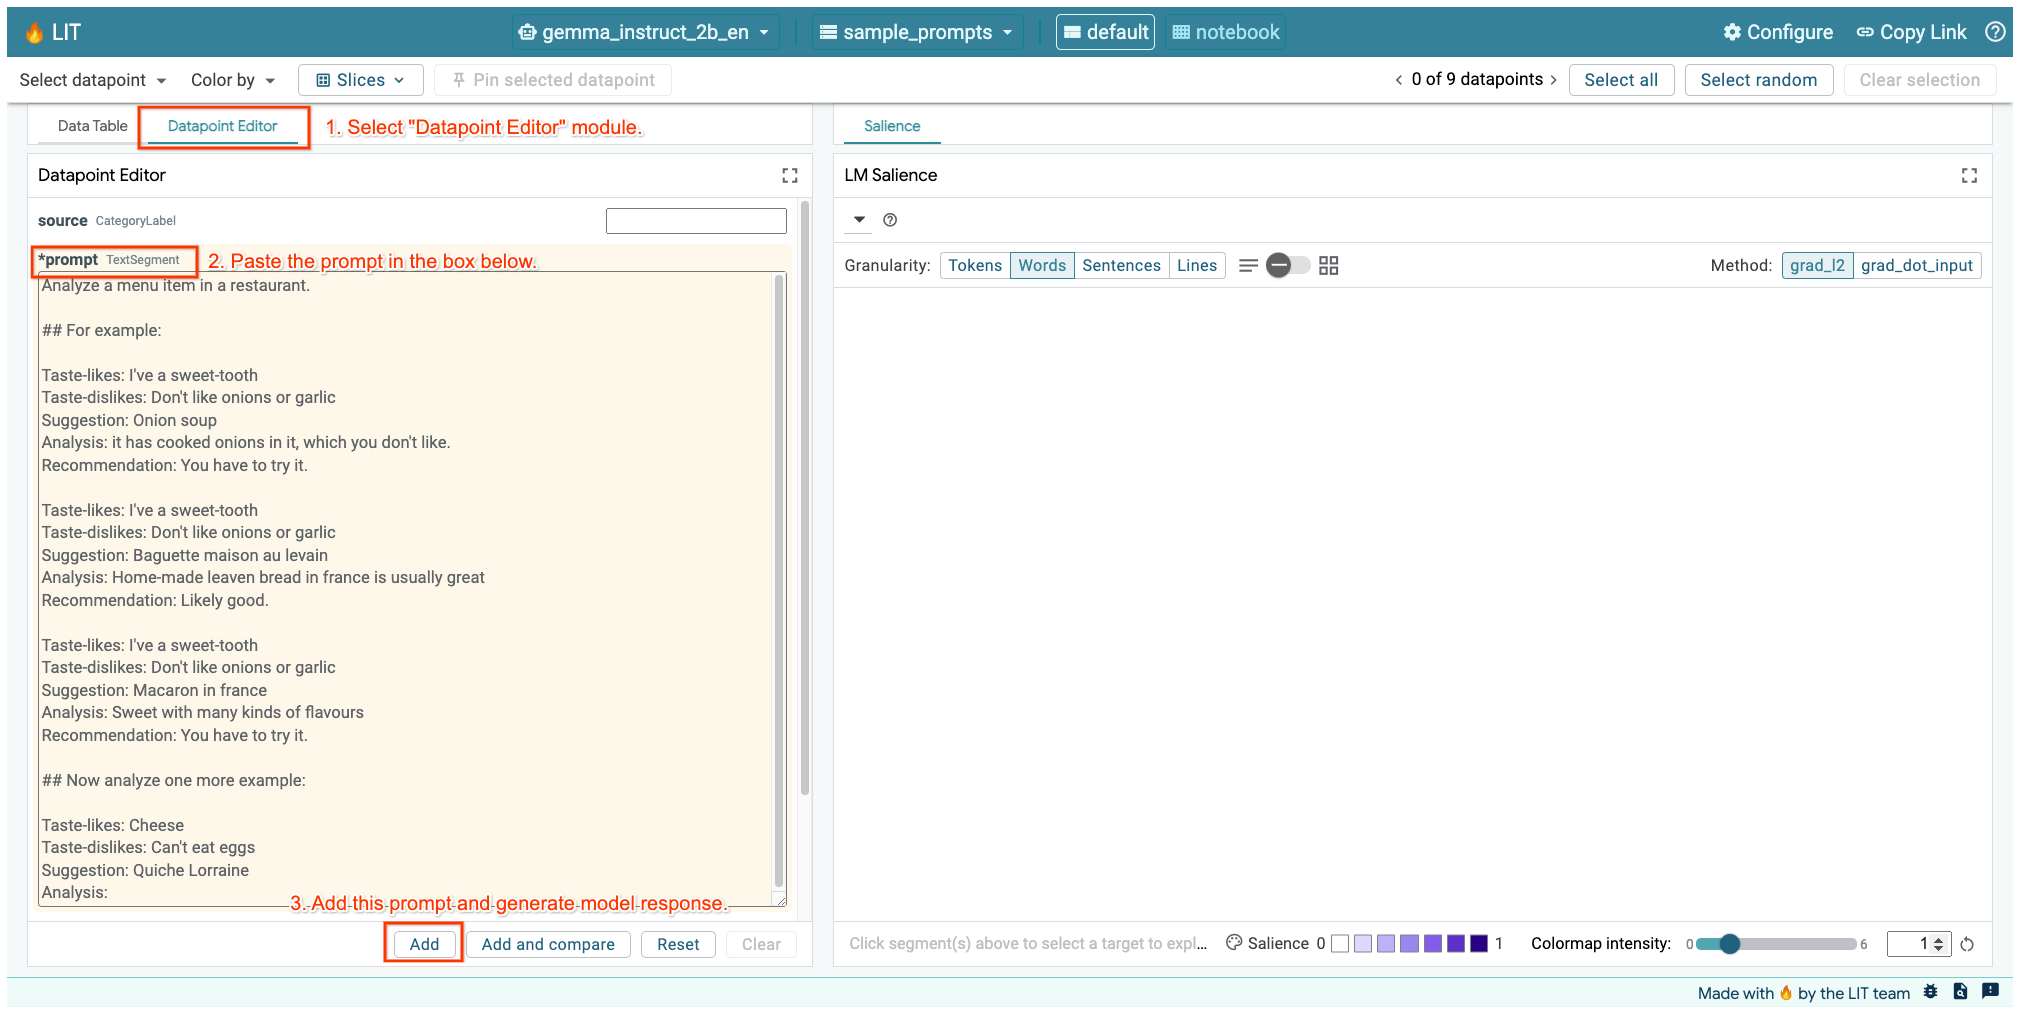

Another way is to re-render the widget directly with the prompt of interest:

In [ ]:
lit_widget.render(data=[fewshot_mistake_example])

<IPython.core.display.Javascript object>

Note the surprising model completion:

```
Taste-likes: Cheese
Taste-dislikes: Can't eat eggs
Suggestion: Quiche Lorraine
Analysis: A savoury tart with cheese and eggs
Recommendation: You might not like it, but it's worth trying.
```
Why is the model suggesting you eat something that you clearly said you can't
eat?

Sequence salience can help highlight the root problem, which is in our few-shot
examples. In the first example, the chain-of-thought reasoning in the analysis
section `it has cooked onions in it, which you don't like` doesn't match the
final recommendation `You have to try it`.

In the LM Salience module, select "Sentences" and then select the recommendation
line. The UI should now look as follows:

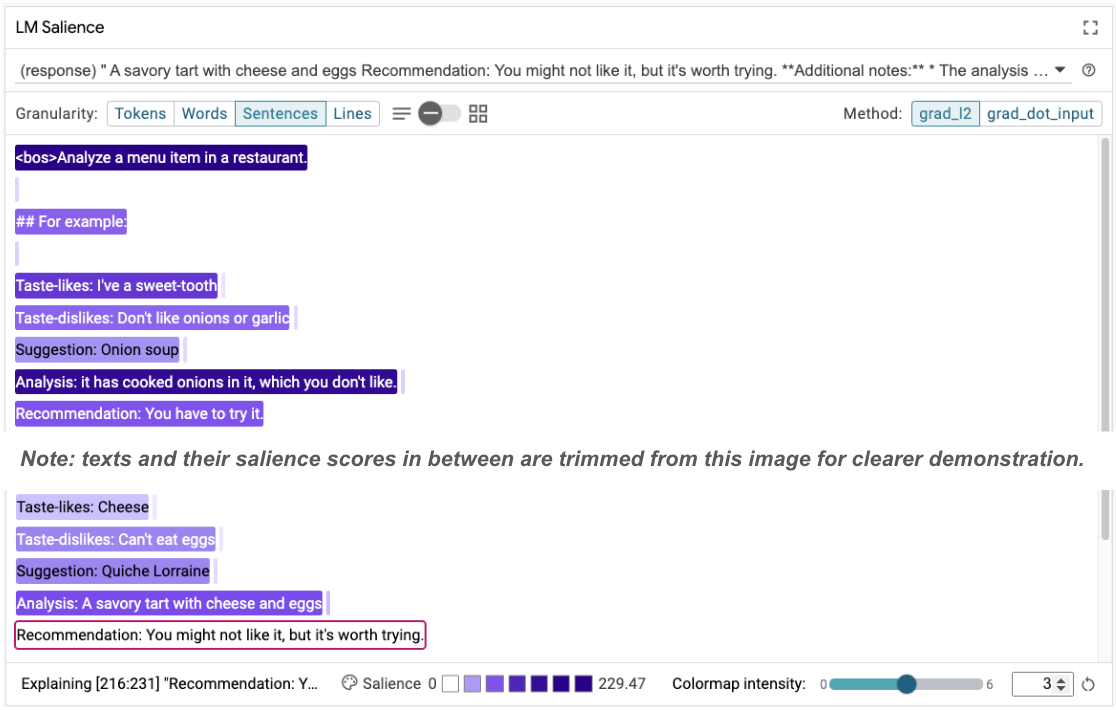

Now lets correct the "Recommendation" in the first example to `Avoid`, and try
again. LIT has this example pre-loaded in the sample prompts, so you can use
this little utility function to grab it:

In [ ]:
def get_fewshot_example(source: str) -> str:
  for example in datasets['sample_prompts'].examples:
    if example['source'] == source:
      return example['prompt']
  raise ValueError(f'Source "{source}" not found in the dataset.')

In [ ]:
lit_widget.render(data=[{'prompt': get_fewshot_example('fewshot-fixed')}])

<IPython.core.display.Javascript object>

Now the model completion becomes:

```
Taste-likes: Cheese
Taste-dislikes: Can't eat eggs
Suggestion: Quiche Lorraine
Analysis: This dish contains eggs and cheese, which you don't like.
Recommendation: Avoid.
```

An important lesson to take away from this is: **early prototyping helps reveal
risks you might not think of ahead of time**, and the error-prone nature of
language models means that one has to proactively design for errors. Further
discussion of this can be found in our [People + AI Guidebook][pair-guidebook]
for designing with AI.

While the corrected few shot prompt is better, it's still not quite right: it
correctly tells the user to avoid eggs, but the reasoning is not right, it says
they don't like eggs, when in fact the user has stated that they can't eat eggs.
In the following section, you'll see how you can do better.

[datapoint-editor]: https://pair-code.github.io/lit/documentation/ui_guide.html#datapoint-editor
[pair-guidebook]: https://pair.withgoogle.com/guidebook/
[pair-salience]: https://pair.withgoogle.com/explorables/saliency/

## Test hypotheses to improve model behavior

LIT enables you to test changes to prompts within the same interface. In this
instance, you're going to test adding a [constitution](https://arxiv.org/abs/2212.08073)
to improve the model's behavior. Constitutions refer to design prompts with
principles to help guide the model's generation. Recent methods even enable
[interactive derivation](https://arxiv.org/pdf/2310.15428.pdf) of
constitutional principles.

Let's use this idea to help improve the prompt further. Add a section with the
principles for the generation at the top of our prompt, which now starts as
follows:

```
Analyze a menu item in a restaurant.

* The analysis should be brief and to the point.
* The analysis and recommendation should both be clear about the suitability for someone with a specified dietary restriction.

## For example:

Taste-likes: I've a sweet-tooth
Taste-dislikes: Don't like onions or garlic
Suggestion: Onion soup
Analysis: it has cooked onions in it, which you don't like.
Recommendation: Avoid.

...

```

In [ ]:
lit_widget.render(data=[{'prompt': get_fewshot_example('fewshot-constitution')}])

<IPython.core.display.Javascript object>

With this update, the example can be rerun and observe a very different output:

```
Taste-likes: Cheese
Taste-dislikes: Can't eat eggs
Suggestion: Quiche Lorraine
Analysis: This dish containts eggs, which you can't eat.
Recommendation: Not suitable for you.
```
The prompt salience can then be re-examined to help get a sense of why this change is happening:

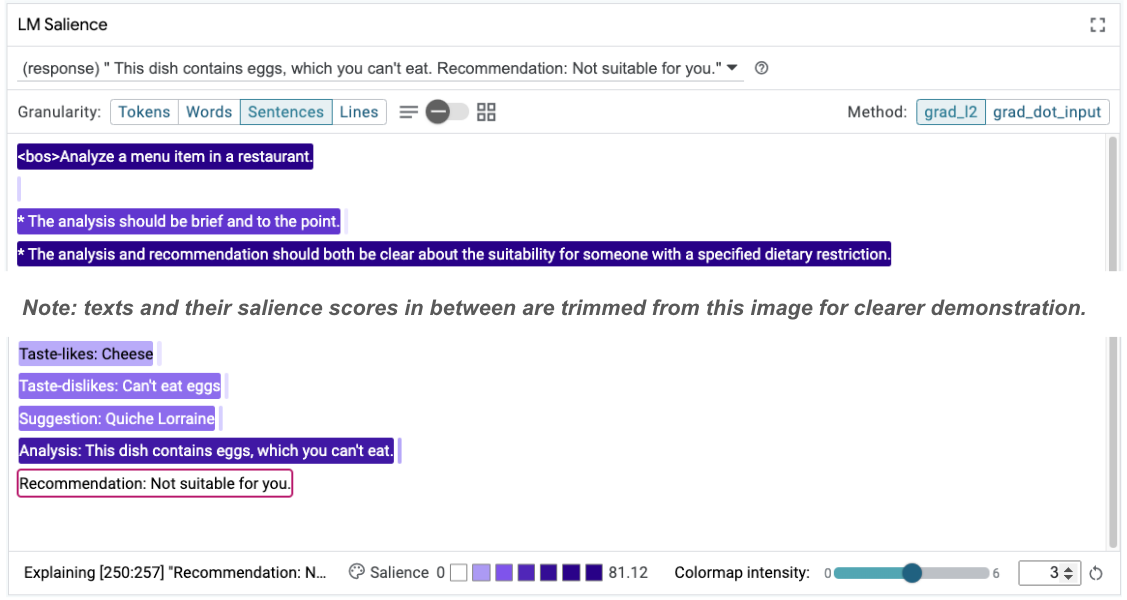

Notice the recommendation is much safer. Furthermore, the "Not suitable for you" is influenced by the principle of clearly stating suitability according to the dietary restriction, along with the analysis (the so-called chain of thought). This helps gives additional confidence that the output is happening for the right reason.

## Include non-technical teams in model probing and exploration

Interpretability is meant to be a team effort, spanning expertise across XAI, policy, legal, and more.

Interacting with models in the early development stages has traditionally required significant technical expertise, which made it more difficult for some collaborators to access and probe them. Tooling has historically not existed to enable these teams to participate in the early prototyping phases.

Through LIT, the hope is that this paradigm can change. As you've seen through
this codelab, LIT's visual medium and interactive ability to examine salience
and explore examples can help different stakeholders share and communicate
findings. This can enable you to bring in a broader diversity of teammates for
model exploration, probing, and debugging. Exposing them to these technical
methods can enhance their understanding of how models work. In addition, a more
diverse set of expertise in early model testing can also help uncover
undesirable outcomes that can be improved.

## Recap

To recap:
* The LIT UI provides an interface for interactive model execution, enabling users to generate outputs directly and test “what if” scenarios. This is particularly useful for testing different prompt variations.
* The [LM Salience module](https://pair-code.github.io/lit/documentation/components.html#token-based-salience) provides a visual representation of salience, and provides controllable data granularity so you can communicate about human-centered constructs (e.g., sentences and words) instead of model-centered constructs (e.g., tokens).

When you find problematic examples in your model evaluations, bring them into LIT for debugging. Start by analyzing the largest sensible unit of content you can think of that logically relates to the modeling task, use the visualizations to see where the model is correctly or incorrectly attending to the prompt content, and then drill down into smaller units of content to further describe the incorrect behavior you’re seeing in order to identify possible fixes.

Lastly: Lit is constantly improving! Learn more about our features and share
your suggestions [here](https://github.com/PAIR-code/lit).

# Appendix: How LIT Computes Sequence Salience

LIT computes sequence salience in a multi-step process.

1. Given an input string (prompt and either the model's generation or a "gold" target sequence), tokenize it for model input.
1. Compute a "target" sequence by [rolling](https://keras.io/api/ops/numpy/#roll-function) the input tokens one position to the left.
1. Extract the embeddings for the and [compute the per-token loss](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) between the generation and the "target" sequences.
1. Mask out the loss to isolate the tokens you're interested in explaining.
1. Use the [`tf.GradientTape.gradient()` function](https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient) to compute the gradients of the input embeddings with regard to the masked loss.
1. Process the gradients to give a single score for each input token. For example, by taking the L2 norm of the gradient at each position.

# Appendix: Computing Salience Programmatically

It's possible to compute salience scores directly from Python, using the same steps above that the LIT tool runs internally. You'll do this in three steps:

1. Prepare an example and run the model tokenizer,
1. Prepare a mask which selects which (predicted) tokens to explain,
1. Call the salience wrapper.

In [ ]:
#@title Make input example for LIT
example = {
    'prompt': 'Keras is a',
    'target': ' deep learning library for Python that provides a wide range of tools and functionalities for building, training, and evaluating deep learning models.\n\n**'
}
example

{'prompt': 'Keras is a',
 'target': ' deep learning library for Python that provides a wide range of tools and functionalities for building, training, and evaluating deep learning models.\n\n**'}

A note on calling conventions: both the tokenizer and the salience wrapper use LIT's [Model API](https://pair-code.github.io/lit/documentation/api.html#models), where the `.predict()` function takes a list of examples (dicts) and returns a _generator_ of responses (dicts). This is much more flexible when working with larger datasets or slower models, but means that if you just want predictions on one example, now, you do need to wrap it with something like: `list(model.predict([example])[0]`

In [ ]:
#@title Get tokens so you can select explanation targets
tokenizer = models[f"_{model_name}_tokenizer"].predict
tokens = list(tokenizer([example]))[0]['tokens']
tokens

array(['<bos>', 'K', 'eras', '▁is', '▁a', '▁deep', '▁learning',
       '▁library', '▁for', '▁Python', '▁that', '▁provides', '▁a', '▁wide',
       '▁range', '▁of', '▁tools', '▁and', '▁functionalities', '▁for',
       '▁building', ',', '▁training', ',', '▁and', '▁evaluating', '▁deep',
       '▁learning', '▁models', '.', '\n\n', '**'], dtype='<U16')

To compute salience, you need to make a target mask which specifies which (predicted) tokens to explain. The target mask will be an array the same length as tokens, with 1s in the positions of the tokens you want to explain. Let's use `▁training` and `▁evaluating` as our target:

In [ ]:
#@title Prepare target mask
import numpy as np

target_start = list(tokens).index("▁training")
target_end = list(tokens).index("▁evaluating")

# Prepare our mask
target_mask = np.zeros(len(tokens), dtype=np.float32)
target_mask[target_start:target_end+1] = 1
target_mask

# Add to our LIT input
example_for_salience = example | {'target_mask': target_mask}
example_for_salience

{'prompt': 'Keras is a',
 'target': ' deep learning library for Python that provides a wide range of tools and functionalities for building, training, and evaluating deep learning models.\n\n**',
 'target_mask': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       dtype=float32)}

In [ ]:
#@title Call the salience model
compute_salience = models[f"_{model_name}_salience"].predict
salience = list(compute_salience([example_for_salience]))
salience[0]

{'grad_l2': array([45.75, 36.75, 61, 5.40625, 4.09375, 5.625, 6.46875, 7.3125, 3.375,
        5.03125, 3.23438, 4.5625, 2.375, 3.40625, 2.75, 1.97656, 3.95312,
        3.42188, 14.125, 4.53125, 11.375, 12.625, 18.5, 4.5625, 6.5, 0, 0,
        0, 0, 0, 0, 0], dtype=bfloat16),
 'grad_dot_input': array([-4.03125, 3.04688, -7.03125, -0.800781, 0.769531, -0.679688,
        -0.304688, 2.04688, 0.275391, -1.25781, -0.376953, -0.0664062,
        -0.0405273, -0.357422, 0.355469, -0.145508, -0.333984, 0.0181885,
        -5.0625, 0.235352, -0.470703, 2.25, 3.90625, -0.199219, 0.929688,
        0, 0, 0, 0, 0, 0, 0], dtype=bfloat16),
 'tokens': array(['<bos>', 'K', 'eras', '▁is', '▁a', '▁deep', '▁learning',
        '▁library', '▁for', '▁Python', '▁that', '▁provides', '▁a', '▁wide',
        '▁range', '▁of', '▁tools', '▁and', '▁functionalities', '▁for',
        '▁building', ',', '▁training', ',', '▁and', '▁evaluating', '▁deep',
        '▁learning', '▁models', '.', '\n\n', '**'], dtype='<U16')}

And there you go! The scores in the `grad_l2` and `grad_dot_input` fields are aligned to `tokens`, and are the same as you'd see in the LIT UI.

Note that the last few scores are 0: because our model is a left-to-right language model, tokens to the right of our target span have no influence on the prediction.